# Imports

Installation

In [1]:
!pip install pymorphy2 -q
!pip install datasets transformers -q
! pip install datasets transformers -q

In [52]:
# base
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import io
import json

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# text preprocessing
import nltk
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')

# transformers
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import pipeline
from transformers import DefaultDataCollator
from transformers import pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#from huggingface_hub import notebook_login


#notebook_login()

# Read Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -u /content/drive/MyDrive/KonturTestTask/nlp_test_task_2023.zip

Archive:  /content/drive/MyDrive/KonturTestTask/nlp_test_task_2023.zip


In [5]:
data = pd.read_json('/content/nlp_test_task_2023/dataset/train.json')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [7]:
data.head()

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


# EDA

## Get all features

In [9]:
target_text = []
start = []
end = []
for i in data['extracted_part']:
    
    target_text.append(''.join((i['text'][0])))
    start.append(i['answer_start'][0])
    end.append(i['answer_end'][0])

data['target_text'] = target_text
data['start'] = start
data['end'] = end

#data.drop('extracted_part', axis=1, inplace=True)


Is target class empty or not

In [10]:
data['Empty target'] = data['target_text'].apply(len) == 0

## Class distibution

<Axes: xlabel='label', ylabel='Count'>

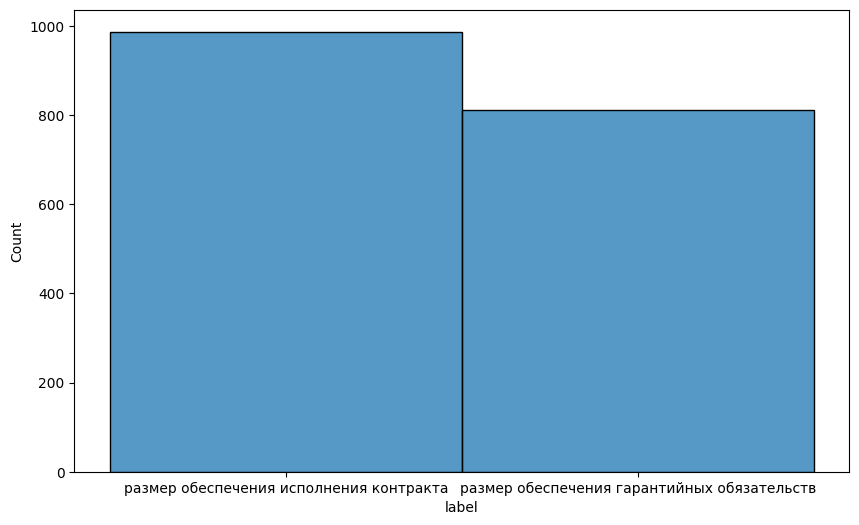

In [18]:
plt.figure(figsize=(10,6))

sns.histplot(
    data=data,
    x='label'
)

There is no imbalance

## Empty answers

As we can see, **most of empty texts** belong to question 'размер обеспечения гарантийных обязательств'

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='Empty target', ylabel='Count'>

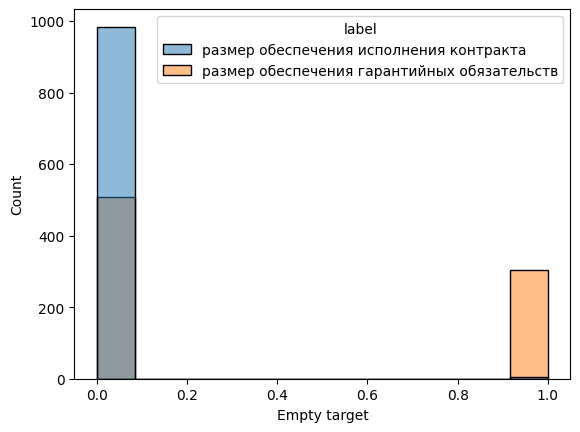

In [49]:
sns.histplot(
    data=data,
    x='Empty target',
    hue='label'
)

## Text Lemmatisation

Function

In [50]:
morph = MorphAnalyzer()

def lemmatize(doc):
    tokens = []
    for token in doc.split():

        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)

    return tokens


Lemmatization of texts

In [51]:
lemmatized = []
for i in data['text'].values:
    lemmatized.append(lemmatize(i))

data['lemmas'] = lemmatized
data['lemmas'] = data['lemmas'].apply(lambda x: ' '.join(x))

Lemmatization of answers

In [52]:
lemmatized = []
for i in data['target_text'].values:
    lemmatized.append(lemmatize(i))

data['answer_lemmas'] = lemmatized
data['answer_lemmas'] = data['answer_lemmas'].apply(lambda x: ' '.join(x))

In [53]:
# Check that after lemmatization we haven't delete some words and haven't changed the lenght of texts

(data['answer_lemmas'].apply(lambda x: len(x.split())) == data['target_text'].apply(lambda x: len(x.split()))).sum()
(data['lemmas'].apply(lambda x: len(x.split())) == data['text'].apply(lambda x: len(x.split()))).sum()

1799

In [54]:
data.head()

,id,text,label,extracted_part,target_text,start,end,Empty target,lemmas,answer_lemmas
0,809436509,Извещение о проведении открытого конкурса в эл...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343,False,извещение о проведение открытый конкурс в элек...,размер обеспечение исполнение контракт 6593.25...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,размер обеспечения исполнения контракта,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318,False,требование к содержание заявка участник запрос...,поставщик должный предоставить обеспечение исп...
2,4382157,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343,False,извещение о проведение электронный аукцион для...,размер обеспечение исполнение контракт 10.00%
3,184555082,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1304,1350,False,извещение о проведение электронный аукцион для...,размер обеспечение исполнение контракт 10.00%
4,211645258,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1302,1348,False,извещение о проведение электронный аукцион для...,размер обеспечение исполнение контракт 10.00%


## Put forward hypotheses

Exploring the data, I have mentioned that word 'размер' is often in answers. Let's see it in details

***First class***

In [56]:
word_names = {
    'size_count':0
}

question = 'размер обеспечения исполнения контракта'

now = data[(data['label'] == question) & (data['target_text'] != '')]
indexes = data[(data['label'] == question) & (data['target_text'] != '')].index
total_len = len(now)

for index in indexes:
    if 'размер' in data.iloc[index]['answer_lemmas']:                 
        word_names['size_count'] += 1
   
print('Not empty target class')
print('The word "размер" is in', word_names['size_count'], 'answers out of', total_len)


Not empty target class
The word "размер" is in 960 answers out of 984


We can see that **in most of answers there is the word 'размер'**

***Second class***

The word "размер" is in 2 samples out of 303 with empty targets
The word "размер" is in 498 samples out of 508 with not empty targets


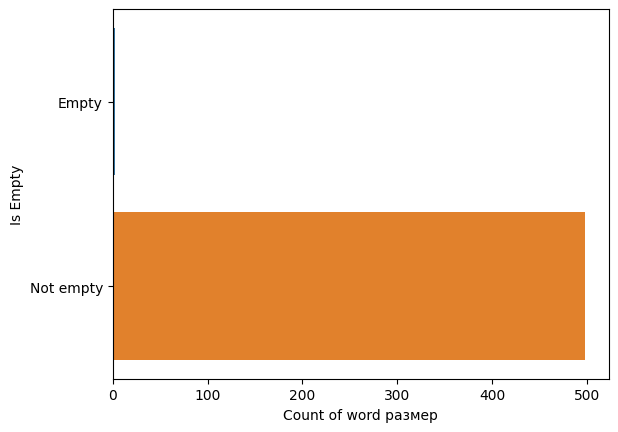

In [60]:
word_names = {
    'size_count_empty': 0,
    'size_count_not_empty': 0,
}

question = 'размер обеспечения гарантийных обязательств'

empty_target_len = len(data[(data['label'] == question) & (data['target_text'] == '')])
empty_target_indexes = data[(data['label'] == question) & (data['target_text'] == '')].index

not_empty_target_len = len(data[(data['label'] == question) & (data['target_text'] != '')])
not_empty_target_indexes = data[(data['label'] == question) & (data['target_text'] != '')].index

total_len = len(now)

for index in empty_target_indexes:
    if 'размер' in data.iloc[index]['lemmas']:                 
        word_names['size_count_empty'] += 1

for index in not_empty_target_indexes:
    if 'размер' in data.iloc[index]['lemmas']:                 
        word_names['size_count_not_empty'] += 1


visualization = pd.DataFrame({
    'Is Empty': ['Empty', 'Not empty'],
    'Count of word размер': [word_names['size_count_empty'], word_names['size_count_not_empty']]
})   

sns.barplot(
            data=visualization,
             x='Count of word размер',
             y='Is Empty')

print('The word "размер" is in', word_names['size_count_empty'], 'samples out of', empty_target_len, 'with empty targets')
print('The word "размер" is in', word_names['size_count_not_empty'], 'samples out of', not_empty_target_len, 'with not empty targets')


Now we can clearly understand that **target text is empty when there no word 'размер'**

That's why i decided to add this word to every question on order to improve predictions. And it really works.

In [72]:
def rename(word):
    word = word.split()
    word[0] = 'обеспечения'
    word = ' '.join(word)
    word = 'размер ' + word

    return word

data['label'] = data['label'].apply(rename)

In [73]:
data.head()

,id,text,label,extracted_part,target_text,start,end,Empty target
0,809436509,Извещение о проведении открытого конкурса в эл...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 6593.2...,1279,1343,False
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,размер обеспечения исполнения контракта,{'text': ['Поставщик должен предоставить обесп...,Поставщик должен предоставить обеспечение испо...,1222,1318,False
2,4382157,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1297,1343,False
3,184555082,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1304,1350,False
4,211645258,Извещение о проведении электронного аукциона д...,размер обеспечения исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,Размер обеспечения исполнения контракта 10.00%,1302,1348,False


# Model

## Select model

***What have I tried?***

I have tried many models, trained only for russian of multilingual models which trained on different datasets (I have even found some models trained on SberQuAD, special dataset for russian language)

***Which models were the best?***

In this case small models were better than large because all models were trained on datasets where answers usually no longer than 3-5 word or even shorter. However, answers in this task are much longer, that's why large models were hardly to learn on this data and small models were trained much more better and faster.

***What have i choosen?***

XLM-roberta was the best choise fot this task.

Hugging Face link: https://huggingface.co/deepset/xlm-roberta-base-squad2-distilled: 

***Model description***

This model was trained for extractive questin answering task.

Training data: SQuAD 2.0 (special dataset for QA tasks)

Language: Multilingual

In [33]:
model_name = 'deepset/xlm-roberta-base-squad2-distilled'
#model_name = 'salti/bert-base-multilingual-cased-finetuned-squad'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

## Prepare data fot the model

*Split the data*

In [34]:
X_train, X_test = train_test_split(data, random_state=24, test_size=0.2)

*Create datasets*

In [35]:
train_dataset = Dataset.from_dict({
    'id': X_train['id'],
    'title': ['a' for i in range(len(X_train))],
    'question': X_train['label'],
    "context": X_train['text'],
    'answers': X_train['extracted_part']
})

test_dataset = Dataset.from_dict({
    'id': X_test['id'],
    'title': ['a' for i in range(len(X_test))],
    'question': X_test['label'],
    "context": X_test['text'],
    'answers': X_test['extracted_part']
})

*Dataset Dictinary*

In [36]:
dataset = DatasetDict({"train":train_dataset,"test":test_dataset})

*Encoder function*

In [37]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]

    inputs = tokenizer(
        questions,
        examples["context"],
        #max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]

        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [38]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [39]:
data_collator = DefaultDataCollator()

## Training

In [40]:
training_args = TrainingArguments(
    output_dir="ducKmooduck/qa",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    num_train_epochs=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.821500,0.713188
2,0.458300,0.578713
3,0.202600,0.507315


TrainOutput(global_step=2160, training_loss=0.437867690898754, metrics={'train_runtime': 726.6802, 'train_samples_per_second': 5.941, 'train_steps_per_second': 2.972, 'total_flos': 1128018098829312.0, 'train_loss': 0.437867690898754, 'epoch': 3.0})

## Save model

In [41]:
trainer.save_model("/content/qa_model")

## See the results on validation

Predict answers using pipeline

In [19]:
model = '/content/qa_model' 

question_answerer = pipeline("question-answering", 
                       model=model,
                       tokenizer=model)
predicted_answers = []
true_answers = []


for index in tqdm(X_test.index, ascii=True, desc='Total'):
    question = data.iloc[index]['label']
    context = data.iloc[index]['text']

    predicted_answer = question_answerer(question=question, context=context)
    #if len(predicted_answer['answer'].split()) <= 2:
        #predicted_answer['answer'] = ''
    predicted_answers.append(predicted_answer['answer'])

    true_answer = data.iloc[index]['extracted_part']['text']
    true_answers.append(true_answer)

Total: 100%|##########| 360/360 [09:33<00:00,  1.59s/it]


Sometimes model can predict extra commas or spaces, here we clean it. Also we clean answers which contain less than 4 words because minimal lenght of answer is 4 words

In [20]:
final = []

for answer in predicted_answers:
    #print(len(final))
    while len(answer) > 0 and ((answer[-1]) == ',' or (answer[-1]) == ' ' or answer[-1] == '-'):
      answer = answer[:-1]
    answer = answer.split()
    if len(answer) <= 3:
      final.append('')
    else:
      final.append(' '.join(answer))

Find indexes of first and last answer's symbols

In [21]:
start_indexes = []
end_indexes = []

for i in range(len(X_test)):
    start = X_test.iloc[i]['text'].find(final[i])
    start_indexes.append(start)

    if start != 0:
        end_indexes.append(start + len(final[i]))
    else:
        end_indexes.append(0)

Number of correct answers

In [22]:
k = 0

for i in range(len(start_indexes)):
    if start_indexes[i] == X_test.iloc[i]['start'] and end_indexes[i] == X_test.iloc[i]['end']:
        k += 1

print('Correct answers are', k, 'of', len(start_indexes))

Correct answers are 171 of 360


# Inference

In [43]:
data_test = pd.read_json('/content/nlp_test_task_2023/dataset/test.json')

In [44]:
data_test.head()

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта


In [45]:
model = '/content/qa_model_2' 

question_answerer = pipeline("question-answering", 
                       model=model,
                       tokenizer=model)
predicted_answers_final = []


for index in tqdm(data_test.index, ascii=True, desc='Total'):
    question = data_test.iloc[index]['label']
    context = data_test.iloc[index]['text']
    predicted_answer = question_answerer(question=question, context=context)
    predicted_answers_final.append(predicted_answer['answer'])

Total: 100%|##########| 318/318 [08:44<00:00,  1.65s/it]


In [46]:
final_final = []

for answer in predicted_answers_final:
    #print(len(final))
    while len(answer) > 0 and ((answer[-1]) == ',' or (answer[-1]) == ' ' or answer[-1] == '-'):
      answer = answer[:-1]
    answer = answer.split()
    if len(answer) <= 3:
      final_final.append('')
    else:
      final_final.append(' '.join(answer))

In [47]:
start_indexes_final = []
end_indexes_final = []

for i in range(len(data_test)):
    start = data_test.iloc[i]['text'].find(final_final[i])
    start_indexes_final.append(start)

    if start != 0:
        end_indexes_final.append(start + len(final_final[i]))
    else:
        end_indexes_final.append(0)

In [48]:
answer = []
for i in range(len(data_test)):
    sample = {}
    
    sample = {
        'text': [final_final[i]],
        'answer_start': [start_indexes_final[i]],
        'answer_end':[end_indexes_final[i]]
    }
    answer.append(sample)
data_test['extracted_part'] = answer

In [49]:
data_test.head()

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,"{'text': [''], 'answer_start': [0], 'answer_en..."
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,"{'text': [''], 'answer_start': [0], 'answer_en..."
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,"{'text': [''], 'answer_start': [0], 'answer_en..."
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,"{'text': [''], 'answer_start': [0], 'answer_en..."


In [54]:
submit = json.dumps(answer, ensure_ascii=False).encode('utf8')

In [55]:
json = io.open("predictions.json", mode="w", encoding="utf-8")
json.write(submit.decode())
json.close()